In [1]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from matplotlib import pyplot as plt
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.dummy import DummyClassifier
!pip install sentence-transformers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.3 MB/s 
     |████████████████████████████████| 5.5 MB 30.8 MB/s 
     |████████████████████████████████| 1.3 MB 50.6 MB/s 
     |████████████████████████████████| 163 kB 72.5 MB/s 
     |████████████████████████████████| 7.6 MB 54.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=ef8199e7281a00dfa97dbe171231db6fd217d2dc3c11829297aa77097c0bf34f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
!pip install -q rnutil


     |████████████████████████████████| 1.5 MB 14.8 MB/s 


In [3]:
!git clone https://github.com/magistery-tps/text-mining.git
!cd text-mining
!conda env create -f environment.yml
!cd datasets/fashion-outfits

Cloning into 'text-mining'...
remote: Enumerating objects: 664, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 664 (delta 86), reused 153 (delta 52), pack-reused 446
Receiving objects: 100% (664/664), 152.97 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (295/295), done.
Checking out files: 100% (56/56), done.
/bin/bash: conda: command not found
/bin/bash: line 0: cd: datasets/fashion-outfits: No such file or directory


In [4]:
import pyarrow.parquet as pq

#df_products = pq.read_table(source='/content/drive/MyDrive/Farfetch/products.parquet').to_pandas()

df_products = pq.read_table(source='/content/text-mining/datasets/fashion-outfits/train_set.parquet').to_pandas()

df_test =pd.read_csv('/content/text-mining/datasets/fashion-outfits/test_set.csv')

df_test=df_test.fillna("")
df_products=df_products.fillna("")

from nltk.corpus import stopwords
stoplist = stopwords.words("english")
stoplist[:20]
def preprocess_ds(ds):
  ds['product_short_description']=ds['product_short_description'].fillna('')
  ds['name']=ds['product_short_description']#+' ' +ds['product_gender']+ ' ' +ds['product_highlights']#+' ' +ds.product_materials[0][0]+ ' '+df_products['product_materials'][1][0]+ ' '+df_products['product_materials'][2][0] + ' '+ds['product_materials'][3][0] #+' '+ds['product_highlights']
  
  ds['name']=ds.name.str.lower()
  ds['product_highlights']=ds.product_highlights.fillna("")
  ds['product_highlights']=ds.product_highlights.fillna("")
  ds['name']=ds['name'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stoplist))

  return ds

In [5]:
f_products=preprocess_ds(df_products)
df_test=preprocess_ds(df_test)

In [6]:
import string   # libreria de cadena de caracteres
import re       # libreria de expresiones regulares

def clean_text_round1(text):
    # pasa las mayusculas del texto a minusculas
    text = text.lower()                                              
    # reemplaza texto entre corchetes por espacio en blanco.. ¿ y \% no se..
    #text = re.sub('\[.*?¿\]\%', ' ', text)   
    text = re.sub('\[', ' ', text)    
    text = re.sub('\]', ' ', text)                      
    # reemplaza signos de puntuacion por espacio en blanco.. %s -> \S+ es cualquier caracter que no sea un espacio en blanco
    text = re.sub('[%s]' % re.escape(string.punctuation), ',', text) 
    # remueve palabras que contienen numeros.
    #text = re.sub('\w*\d\w*', '', text)                              
    return text
round1 = lambda x: clean_text_round1(x)

def clean_text_round2(text):
    # Sacamos comillas, los puntos suspensivos, <<, >>
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(',', ' ', text)
    text = re.sub('  ', ' ', text)
    #text = re.sub('—', ' ', text)
     

    return text
 

# Defino una funcion anonima que al pasarle un argumento devuelve el resultado de aplicarle la funcion anterior a este mismo argumento
round1 = lambda x: clean_text_round1(x)
round2 = lambda x: clean_text_round2(x)

df_products['name']= pd.DataFrame(df_products['name'].apply(round1))
df_products['name']= pd.DataFrame(df_products['name'].apply(round1))

df_products['name']= pd.DataFrame(df_products['name'].apply(round2))
#df_test['name']=df_test['name'].str()
df_test['name']= pd.DataFrame(df_test['name'].apply(round1))
df_test['name']= pd.DataFrame(df_test['name'].apply(round1))

df_test['name']= pd.DataFrame(df_test['name'].apply(round2))

In [7]:
df_products['name']=df_products['name'] +' gender ' +df_products['product_gender'].str.lower()+ ' highlights ' +df_products['product_highlights'].str.lower()#+ds.product_materials[0][0]+ ' '+df_products['product_materials'][1][0]+ ' '+df_products['product_materials'][2][0] + ' '+ds['product_materials'][3][0] #+' '+ds['product_highlights']
df_test['name']=df_test['name'] +' gender ' +df_test['product_gender'].str.lower()+ ' highlights ' +df_test['product_highlights'].str.lower()  #+ds.product_materials[0][0]+ ' '+df_products['product_materials'][1][0]+ ' '+df_products['product_materials'][2][0] + ' '+ds['product_materials'][3][0] #+' '+ds['product_highlights']


In [8]:
!pip install pandarallel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandarallel: filename=pandarallel-1.6.3-py3-none-any.whl size=16463 sha256=5eb4f357c3f1355d5e93e1727e2ee08aef40af0850dabdcb5f76f996e0b6236a
  Stored in directory: /root/.cache/pip/wheels/3c/a4/19/02a1f08d032a017d5d7e22da595aa652ba0a2f2e22de73981b
Successfully built pandarallel


In [9]:
count = CountVectorizer( ngram_range=(1,1), min_df=20, max_df=400000 )
 
    # Ajustamos con los datos. Acá especificamente creamos una matriz documentos-términos
x_count = count.fit_transform(df_products['name'].astype('string'))

In [10]:
tokens=count.inverse_transform(x_count)

In [11]:
list_dict=[]
for t in tokens:
  res = {}
  for element in t:
    res[element]=element.replace(" ","_")
  list_dict.append(res)


In [12]:
setence_token=[]
i=0
for texto in  df_products['name'].values:
  x=0
  palabras = texto.split()
  sentcen_token=''
  palabras_faltante=[]
  for palabra in palabras:
    try:
     
     sentcen_token=sentcen_token+ ' ' +list_dict[i][palabra]
    except: 
      i=i
    try:
     sentcen_token=sentcen_token+ ' ' + list_dict[i][palabra+ ' '+palabras[x+1]]
    except: 
      i=i
    x=x+1
  i=i+1
  setence_token.append(sentcen_token)

In [13]:

import numpy as np
from nltk.util import ngrams

df_products['sentence_tokens']=setence_token
a = df_products['sentence_tokens'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)


ids=np.arange(len(set(words)))

unique_words=set(words)


df_words=pd.DataFrame(ids, list(set(words))).reset_index()

df_words.columns=['words','id']
df_words['id']=df_words['id']+1


In [14]:
import nltk
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

df_products['name_array'] = df_products['sentence_tokens'].parallel_apply(lambda x: nltk.word_tokenize(x))
df_products['name_array'] 


INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


388498    [trench, coat, gender, women, highlights, spre...
20555     [sleeveless, fitted, maxi, dress, gender, wome...
320524    [graphic, print, shoulder, bag, gender, women,...
384203    [two, tone, twisted, band, ring, gender, women...
153580    [colour, block, denim, shirt, gender, women, h...
                                ...                        
152427    [floral, print, short, sleeve, shirt, gender, ...
238045    [asymmetric, logo, buttons, short, wool, dress...
85359     [mixed, print, tank, top, gender, women, highl...
228642    [open, back, double, breasted, blazer, gender,...
86966     [petite, triangle, cup, bikini, top, gender, w...
Name: name_array, Length: 276107, dtype: object

In [15]:
from gensim.models.word2vec import Word2Vec
import pandas as pd
import numpy as np
import nltk




model = Word2Vec(df_products['name_array'] ,
                 sg=1,           
                 window=5, 

                 size =300 ,    
                 min_count=1,     
                 workers=1,
                 iter=30)        
model.init_sims(replace=True) 

In [16]:
from pandas.compat import np_version_under1p18
embeddings=[]
for w  in df_products['name_array'].values:
  word_embedding=[]
  for element in w:
    word_embedding.append(model.wv.get_vector(element))
  a=np.array(word_embedding)
  avg=np.average(a, axis=0)
  embeddings.append(avg)

In [17]:
embeddings[0]

array([-9.71075264e-04, -2.50738002e-02, -8.86600465e-03, -3.19891311e-02,
       -4.86887470e-02, -3.39005515e-02, -7.10837450e-03,  1.71072297e-02,
       -4.80033690e-04, -1.53895961e-02, -9.71758459e-03, -7.86391646e-03,
        1.94867123e-02, -2.93197129e-02,  3.39906514e-02,  1.43000679e-02,
       -3.86044085e-02, -1.66429318e-02,  6.77399337e-04,  2.34096907e-02,
        4.60993275e-02, -8.94826837e-03, -9.76843387e-03,  7.28987157e-02,
        5.38688339e-02,  2.78649442e-02, -6.12747041e-04, -3.44454907e-02,
       -1.63135992e-04, -9.66930483e-03,  4.88258414e-02, -1.31469434e-02,
        7.11467788e-02,  1.76973194e-02, -3.71191092e-02,  5.65177947e-02,
        5.63287933e-04, -4.22524735e-02, -1.85675046e-03,  1.26810055e-02,
        1.11948671e-02,  6.55423338e-03,  1.21314982e-02, -2.73115169e-02,
       -1.65464170e-02,  9.39113274e-03,  6.59007393e-03,  3.96306738e-02,
        5.31706810e-02,  3.96151282e-02,  2.74919607e-02,  1.96978613e-03,
        4.19657566e-02, -

In [18]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import gc

encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(df_products.branch)


In [19]:
del(df_products)
del(setence_token)

In [20]:
del(list_dict)
gc.collect()

66

In [21]:
import numpy as np
arr = np.array(embeddings)

In [22]:
arr.shape

(276107, 300)

In [23]:
from sklearn.decomposition import TruncatedSVD 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from matplotlib.rcsetup import validate_aspect
from keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D,Dropout

y=transfomed_label
x=arr
#del(arr)
n,d_in=arr.shape
#x=np.asfarray(x,float)


_,d_out=y.shape



# Creo un modelo Red Neuronal 
modelo = keras.Sequential([
    # input_shape solo en la primer capa
    # Capa con 2 salidas, activación relu
    #keras.layers.Conv2D( 128, kernel_size=(3,3),activation='relu'),
    #keras.layers.Embedding(len(df_words), 500, input_length=d_in),
    keras.layers.Dense(2048,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),input_shape=(d_in,), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros'),

    #keras.layers.Bidirectional(keras.layers.LSTM(100),merge_mode='concat'),
   # keras.layers.Flatten(),
    #keras.layers.Dense(5096,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="tanh",kernel_initializer='he_uniform', bias_initializer='zeros'),
   # keras.layers.Dense(2048,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros'),

    keras.layers.Dense(1024,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros'),
    keras.layers.Dense(512,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros'),
    keras.layers.Dense(256,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros'),

    #keras.layers.Dense(128,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros'),
    #keras.layers.Dense(64,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros' ),
    #keras.layers.Dense(32,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros',  ),
   # keras.layers.Dense(2028,kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation="relu",kernel_initializer='he_uniform', bias_initializer='zeros',  ),

    #keras.layers.Dropout(0.4),
    #la ultima capa si o si tiene que tener tantas salidas como valores a predecir
    keras.layers.Dense(d_out,activation="softmax" )])

# visualización del modelo inicial (si hay solo 2 variables de entrada)
#if d_in==1:
#    rnutil.plot_regression1D(modelo,x,y,title=f"Modelo inicial",xlabel=column,ylabel="Consumo")


modelo.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001), 
  loss=tf.keras.losses.CategoricalCrossentropy(), 
  # metricas para ir calculando en cada iteracion o batch 
  # Agregamos el accuracy del modelo
  metrics=['accuracy'], 
)

# Entrenamiento del modelo
print("Entrenando....")
history = modelo.fit(x,y,epochs=30,batch_size=1025,verbose=True, validation_split = 0.2)
#rnutil.plot_training_curves(history)

history_frame = pd.DataFrame(history.history)

Entrenando....
Epoch 1/30
216/216 [==============================] - 6s 13ms/step - loss: 2.9217 - accuracy: 0.5413 - val_loss: 1.9654 - val_accuracy: 0.6870
Epoch 2/30
216/216 [==============================] - 2s 11ms/step - loss: 1.7501 - accuracy: 0.7222 - val_loss: 1.5999 - val_accuracy: 0.7413
Epoch 3/30
216/216 [==============================] - 2s 11ms/step - loss: 1.5103 - accuracy: 0.7536 - val_loss: 1.4299 - val_accuracy: 0.7639
Epoch 4/30
216/216 [==============================] - 2s 11ms/step - loss: 1.3737 - accuracy: 0.7692 - val_loss: 1.3466 - val_accuracy: 0.7648
Epoch 5/30
216/216 [==============================] - 2s 11ms/step - loss: 1.2837 - accuracy: 0.7768 - val_loss: 1.2689 - val_accuracy: 0.7748
Epoch 6/30
216/216 [==============================] - 2s 11ms/step - loss: 1.2127 - accuracy: 0.7844 - val_loss: 1.1979 - val_accuracy: 0.7836
Epoch 7/30
216/216 [==============================] - 2s 11ms/step - loss: 1.1554 - accuracy: 0.7887 - val_loss: 1.1421 - val_a

In [24]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              616448    
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 194)               49858     
                                                                 
Total params: 3,420,610
Trainable params: 3,420,610
Non-trainable params: 0
_________________________________________________________________


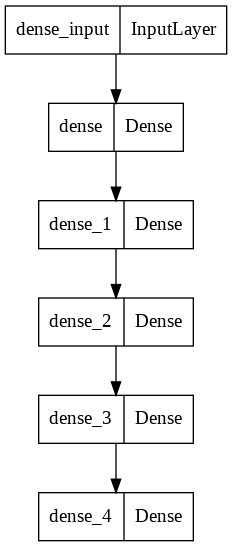

In [25]:
tf.keras.utils.plot_model(modelo)

In [26]:
x_count_test = count.transform(df_test['name'])
tokens_test=count.inverse_transform(x_count_test)
list_dict=[]
for t in tokens_test:
  res = {}
  for element in t:
    res[element]=element.replace(" ","_")
  list_dict.append(res)

In [27]:
setence_token=[]
i=0
for texto in  df_test['name'].values:
  x=0
  palabras = texto.split()
  sentcen_token=''
  palabras_faltante=[]
  for palabra in palabras:
    try:
     
     sentcen_token=sentcen_token+ ' ' +list_dict[i][palabra]
    except: 
      i=i
    try:
     sentcen_token=sentcen_token+ ' ' + list_dict[i][palabra+ ' '+palabras[x+1]]
    except: 
      i=i
    x=x+1
  i=i+1
  setence_token.append(sentcen_token)

In [28]:
df_test['sentence_token']=setence_token

In [29]:
del(x_count)

In [30]:
del(df_test['name'])

In [31]:
del(setence_token)

In [32]:
gc.collect()

2337

In [33]:


df_test['name_array'] = df_test['sentence_token'].parallel_apply(lambda x: nltk.word_tokenize(x))
df_test['name_array'] 


0         [archive, graphic, print, hoodie, gender, men,...
1          [feather, hem, shirt, gender, women, highlights]
2         [logo, print, joggers, gender, men, highlights...
3         [logo, embroidered, mock, neck, top, gender, w...
4         [zigzag, embossed, logo, slides, gender, women...
                                ...                        
118327    [detachable, sleeves, zip, up, jacket, gender,...
118328    [line, mini, skirt, gender, women, highlights,...
118329    [slogan, print, oversized, vest, gender, women...
118330    [reversible, metallic, trim, zipped, jacket, g...
118331    [appliqué, detail, long, sleeve, top, gender, ...
Name: name_array, Length: 118332, dtype: object

In [34]:
from pandas.compat import np_version_under1p18
embeddings=[]
for w  in df_test['name_array'].values:
  word_embedding=[]
  for element in w:
    try:
      word_embedding.append(model.wv.get_vector(element))
    except:
      1==1

  a=np.array(word_embedding)
  avg=np.average(a, axis=0)
  embeddings.append(avg)

In [35]:
arr_test = np.array(embeddings)
arr_test=np.asfarray(arr_test,float)
y_predicted=modelo.predict(arr_test)

3698/3698 [==============================] - 6s 2ms/step


In [36]:
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
test_predictions = np.argmax(y_predicted, axis=-1)
y_real_test = encoder.fit_transform(df_test.branch)
from sklearn.metrics import accuracy_score
real=np.argmax(y_real_test, axis=-1)
acc=accuracy_score(real,test_predictions )
print(acc)

0.8070682486563229


In [37]:
from sklearn.metrics import classification_report as cr

metrics=(cr(real,test_predictions))
print(metrics)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.96      0.85      0.90       180
           1       0.55      0.71      0.62        45
           2       0.88      0.94      0.91       278
           3       0.54      0.32      0.40        41
           4       0.97      0.98      0.97      2057
           5       0.99      0.96      0.97       203
           6       0.88      0.86      0.87        35
           7       0.84      0.46      0.59        35
           8       0.71      0.21      0.33        47
           9       0.00      0.00      0.00        37
          10       0.38      0.07      0.11        74
          11       0.33      0.05      0.09        37
          12       0.60      0.32      0.42        77
          13       0.32      0.11      0.17        62
          14       0.00      0.00      0.00        50
          15       0.57      0.06      0.11        64
          16       0.67      0.25      0.36        56
          17       0.80    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
prediccion=encoder.inverse_transform(modelo.predict(arr_test))
resultados=pd.DataFrame(df_test.branch)
resultados['prediction']=list(prediccion)
resultados.to_csv('rn-word2vect_avg-real-target.csv')

3698/3698 [==============================] - 8s 2ms/step
